Analysis of a Multi-Class Dataset by Projection onto a Very High-dimensional Feature Space

Note: To run this notebook again, the dataset must be in the same folder as the notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import random

# Read the data
df = pd.read_csv('accent-mfcc-data-1.data', header=None)
df.columns = ['language','feature_1','feature_2','feature_3','feature_4','feature_5','feature_6','feature_7','feature_8','feature_9','feature_10','feature_11','feature_12']
X = df[df.columns[1:]].values
y = df[df.columns[0]].values
y_names = np.unique(y)
enc =  OneHotEncoder()
y = enc.fit_transform(y.reshape(-1,1)).toarray()
y = np.array([np.argmax(y[i]) for i in range(y.shape[0])])


In [2]:
def svd(X):
    '''
    Compute the SVD of the data matrix X
    '''
    # compute svd
    U, S, V = np.linalg.svd(X, full_matrices=False)
    return U, S, V

def pca(X,k):
    '''
    Compute the first k principal components of the data matrix X
    '''
    # center the data
    X = X - np.mean(X, axis=0)
    # compute svd
    U, S, V = svd(X)
    # return the first k principal components
    V = V.T
    # project the data onto the principal components
    Z = X @ V[:, :k]
    return Z

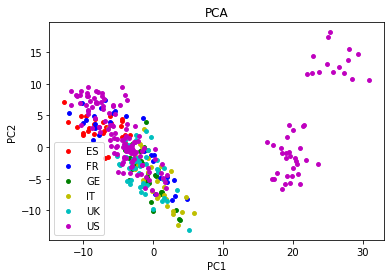

In [3]:
colours = ['r','b','g','y','c','m','k']
u = pca(X,2)
# plot the data
plt.figure()
for g in np.unique(y):
    plt.scatter(u[y==g,0], u[y==g,1], label=y_names[g], color=colours[g], s=15)
plt.legend()
# add title and axis names
plt.title('PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()

Discussion 1: Linearly Seperable in 2D

The data is not linearly seperable in 2d after visual inspection because there cannot exist a line on the graph which seperates the cluster on the left as the data points from different classes are clumped together randomly. Thus the data cannot be classified using pca using 2 components in the original feature space.

Task 2: multi class perceptron algorithm with bias


In [4]:
# multiclass perceptron with bias
def multiclass_perceptron(X,y,epochs):
    ''' 
    Train a multiclass perceptron with bias
    X: data matrix
    y: labels
    epochs: number of iterations
    '''
    n = X.shape[0]
    # add bias column
    X = np.concatenate((X,np.ones((n,1))),axis=1)
    # initialize weights
    k = np.unique(y).shape[0]
    w = np.zeros((X.shape[1],k))
    # train
    for t in range(epochs):
        errors = 0
        # join X and y
        J = np.concatenate((X,y.reshape(-1,1)),axis=1)
        # shuffle J
        np.random.shuffle(J)
        # split J
        X = J[:,:-1]
        y = J[:,-1]

        for i in range(n):
            # predict
            y_hat = 0
            for c in range(k):
                if np.dot(X[i],w[:,c]) >= np.dot(X[i],w[:,y_hat]):
                    y_hat = c
            # update
            if y[i] != y_hat:
                errors += 1
                w[:,int(y[i])] += X[i]
                w[:,y_hat] -= X[i]
        
        if errors == 0:
            break
        # print('Epoch: %d, Errors: %d' % (t,errors))
    return w

w = multiclass_perceptron(X,y,epochs=10)
w.shape

(13, 6)

In [5]:
def predict(X,w):
    '''
    Predict labels for data matrix X
    X: data matrix
    w: weights
    '''
    # add bias
    X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
    # predict
    y_hat = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        for c in range(w.shape[1]):
            if np.dot(X[i],w[:,c]) >= np.dot(X[i],w[:,int(y_hat[i])]):
                y_hat[i] = c
    return y_hat

def errors(y,y_hat):
    '''
    Compute the number of errors
    y: true labels
    y_hat: predicted labels'''
    return np.sum(y!=y_hat)

In [6]:
# Calulate the errors when using the first 12 principal components
for i in range(12):
    u = pca(X,i+1)
    w = multiclass_perceptron(u,y,epochs=10)
    y_hat = predict(u,w)
    print('Components: %d, Errors: %s' % (i+1,errors(y,y_hat)))
    

Components: 1, Errors: 261
Components: 2, Errors: 236
Components: 3, Errors: 205
Components: 4, Errors: 168
Components: 5, Errors: 173
Components: 6, Errors: 142
Components: 7, Errors: 147
Components: 8, Errors: 117
Components: 9, Errors: 133
Components: 10, Errors: 136
Components: 11, Errors: 114
Components: 12, Errors: 108


Discussion 2: Linearly Seperable in Any Dimension

The data is not linearly seperable in any dimension using linear PCA (svd) and the perceptron algorithm as seen in the cell above because the error is not zero with any number of top components. This suggests that the data has not got a linear distribution and non-linear pca should be used.

Task 3: Normalised Kernel Matrix

In [7]:
def get_gammas(X, e):
    '''
    Compute the gammas for the RBF kernel
    X: data matrix
    e: small number
    '''
    # center the data
    X = X - np.mean(X, axis=0)
    #  compute variances
    variances = np.var(X, axis=0)
    var_max = np.max(variances)
    var_min = np.min(variances)
    # compute gammas
    gamma_min = 1/(2*var_max+e)
    gamma_max = 1/(2*var_min-e)

    interval = ((gamma_max - gamma_min)/0.01).astype(int)
    gammas = np.linspace(gamma_min, gamma_max, interval)
    return gammas
    

def normalise_kernel(K):
    ''' 
    Normalise the kernel matrix K
    K: kernel matrix
    '''
    n = K.shape[0]
    A = np.ones((n,n))/n
    return K - A.dot(K) - K.dot(A) + A.dot(K).dot(A)

def rbf_kernel(X,gamma):
    '''
    Compute the RBF kernel
    X: data matrix
    gamma: parameter
    '''
    K = np.zeros((X.shape[0],X.shape[0]))
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            K[i,j] = np.exp((-gamma*(np.linalg.norm(X[i]-X[j])**2)))    
    K = normalise_kernel(K)
    return K


Task 4: Grid Search Matrix

In [8]:
def grid_search(X,y,e):
    ''' 
    Perform a grid search for the best gamma and number of top components
    X: data matrix
    y: labels
    e: small number
    '''
    n = X.shape[0]
    # get gammas
    gammas = get_gammas(X,e)
    grid = []

    for gamma in gammas:
        # compute kernel
        K = rbf_kernel(X,gamma)
        row = []
        # for each possible number of top components
        for i in range(0,n):
            # compute top components
            u = pca(K,i)
            # train
            w = multiclass_perceptron(u,y,epochs=10)
            # predict
            y_hat = predict(u,w)
            # compute errors
            row.append(errors(y,y_hat))
        grid.append(row)


    # transpose the grid
    grid = np.array(grid).T
    # find first 0 in grid
    top_comp = 1000000
    gam = 0
    for i in range(len(X)):
        if 0 in grid[i]:
            for j in range(len(gammas)):
                if grid[i][j] == 0:
                    top_comp = i
                    gam = gammas[j]
                    break
            break
    print('[HYPERPARAMETERS] Top components: %d, Gamma: %f' % (top_comp,gam))

    # truncate the grid
    grid = grid[:top_comp+1,:]

    # flip the grid
    grid = np.flip(grid,axis=0)

    # principal components
    pcs = np.arange(0,top_comp+1,1)

    # gammas
    round_gammas = np.round(gammas,3)

    return pcs, round_gammas, grid

pcs, gammas, grid = grid_search(X,y,e=0.05)

[HYPERPARAMETERS] Top components: 288, Gamma: 0.081605


Discussion 3: Linearly Separable in a Non-Linear Feature Space

The data is linearly separable in a non-linear feature space defined by the normalised radial basis kernel. This is because the perceptron algorithm can run and output a matrix w such that when the predictions are made, there are no errors. The radial basis function changes the basis of the feature matrix to a basis where the data is linearly seperable, this new matrix can be used in linear pca and the perceptron algorithm to find a solution. The minimum number of top components and the best value of gamma is given above in a print statement.

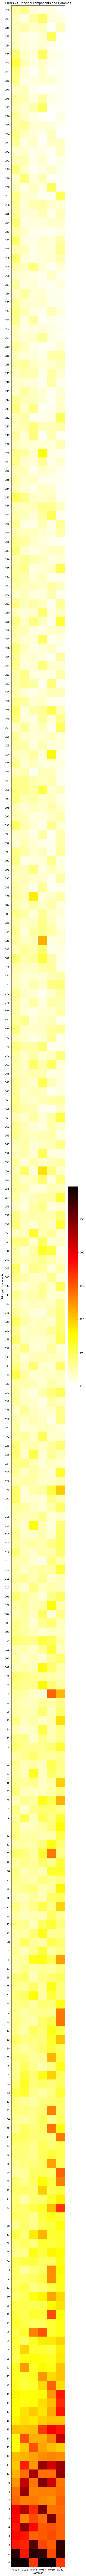

In [9]:
# plot the matrix
fig, ax = plt.subplots(figsize=(5,500))


plt.imshow(grid, cmap='hot_r')
plt.colorbar(cmap='hot_r')
plt.title("Errors vs. Principal components and Gammas")
plt.xlabel('Gammas')
plt.ylabel('Principal components')
ax.xaxis.set_ticks(range(len(gammas)))
ax.xaxis.set_ticklabels(gammas)
ax.yaxis.set_ticks(range(len(pcs)))
ax.yaxis.set_ticklabels(np.flip(pcs))

plt.show()